In [1]:
import pandas as pd
import numpy as np
import xarray as xr


import os
import sys
import logging
import warnings


import geopandas as gpd
from shapely.geometry import Point, Polygon

import ee


from weatherMan import get_available_forecasts , get_latest_forecast_url, calculate_gdd





In [2]:

warnings.filterwarnings('ignore')
# Set up logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# from gefs_downloader_processor_fixed import *

# trace dem fields

In [3]:
field_1 =     [
      [
        -93.8937127,
        41.030578
      ],
      [
        -93.8912445,
        41.0305214
      ],
      [
        -93.8908904,
        41.0278829
      ],
      [
        -93.8924464,
        41.0278181
      ],
      [
        -93.8926611,
        41.0286356
      ],
      [
        -93.8936483,
        41.0289189
      ],
      [
        -93.8937127,
        41.030578
      ]
    ]

field_2 =     [
      [
        -93.8936617,
        41.0307211
      ],
      [
        -93.8841323,
        41.0306887
      ],
      [
        -93.8837889,
        41.0376486
      ],
      [
        -93.888897,
        41.0414035
      ],
      [
        -93.8934042,
        41.0411445
      ],
      [
        -93.8936617,
        41.0307211
      ]
    ]

field_3 = [
      [
        -93.8908841,
        41.0306155
      ],
      [
        -93.8865486,
        41.0306965
      ],
      [
        -93.8862804,
        41.0287621
      ],
      [
        -93.8876969,
        41.0285436
      ],
      [
        -93.8877935,
        41.0278475
      ],
      [
        -93.8905299,
        41.0277909
      ],
      [
        -93.8908626,
        41.0305508
      ]
    ]


field_4 =    [
      [
        -93.8839023,
        41.0379907
      ],
      [
        -93.8838594,
        41.0275344
      ],
      [
        -93.8795669,
        41.028279
      ],
      [
        -93.8791805,
        41.0362751
      ],
      [
        -93.8839023,
        41.0379907
      ]
    ]



# define our farm 

In [4]:
farm = [field_1, field_2, field_3, field_4]
farm = [Polygon(field) for field in farm]
farmGPD = gpd.GeoDataFrame(geometry=farm)
farmGPD.crs = "EPSG:4326"
farmGPD['field'] = ['field_1', 'field_2', 'field_3', 'field_4']
farm_ttl = farmGPD.geometry.union_all().envelope

In [5]:
farm_centre = farm_ttl.centroid.coords
farmX = farm_centre[0][0]
farmY = farm_centre[0][1]

In [6]:
url, model_date, model_run = get_latest_forecast_url()

2025-05-02 00:01:40,852 - weatherMan - INFO - gefs_pgrb2ap5_all_00z is available


# get the forecasts for Precip, temp , soil temp, soil Moist


In [ ]:
ds = xr.open_dataset(url)
ds_sub = ds[['apcpsfc','tmp2m','tsoil0_10cm','soilw0_10cm']].sel(lon= farmX + 360, lat=farmY, method='nearest')
# ds_sub = ds_sub.time.shift(-1) # ONLY FOR PRECIP > AS IT IS THE ACUUMULATION OVER THE PRIOR 6 HOURS AKA apcpsfc
df = ds.to_dataframe()
current_forecast = df.reset_index()
current_forecast.to_csv('current_forecast.csv', index=False)

In [7]:
current_forecast = pd.read_csv('current_forecast.csv')
current_forecast['time'] = pd.to_datetime(current_forecast['time'])

In [8]:

current_forecast['time'] = pd.to_datetime(current_forecast['time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
current_forecast['day'] = current_forecast['time'].dt.day
current_forecast['month'] = current_forecast['time'].dt.month

In [9]:
current_forecast.head()

,ens,time,apcpsfc,tmp2m,tsoil0_10cm,soilw0_10cm,lat,lon,day,month
0,1.0,2025-05-01 00:00:00,NaN,288.54290,287.22680,0.266,41.0,266.0,1,5
1,1.0,2025-05-01 06:00:00,0.05,285.21848,286.50217,0.267,41.0,266.0,1,5
2,1.0,2025-05-01 12:00:00,0.91,285.13730,285.74600,0.271,41.0,266.0,1,5
3,1.0,2025-05-01 18:00:00,1.10,291.47820,286.74600,0.274,41.0,266.0,1,5
4,1.0,2025-05-02 00:00:00,0.76,288.86386,287.79678,0.271,41.0,266.0,2,5


In [10]:
'''
OBJECTIVE:
1. MERGE THE SEASONAL ONTO THE FORECAST
2. GET THE ANOM 

TODO :
    - TEMP / Ready 
    - PRECIP / Hitstory Missin 
    - SOILW / Missing and harmonisation required. 
    - SOIL TEMP / Missing / need to search CPC 

'''

'\nOBJECTIVE:\n1. MERGE THE SEASONAL ONTO THE FORECAST\n2. GET THE ANOM \n\nTODO :\n    - TEMP / Ready \n    - PRECIP / Hitstory Missin \n    - SOILW / Missing and harmonisation required. \n    - SOIL TEMP / Missing / need to search CPC \n\n'

## TEMP 

In [11]:
kelvin = 273.15

In [12]:
farmSeasonal = pd.read_csv('farmSeasonal.csv')
farmSeasonal['day'] = farmSeasonal['date'].str.split('-').str[1].astype(int)
farmSeasonal['month'] = farmSeasonal['date'].str.split('-').str[0].astype(int)
farmSeasonal['seasonal_gdd'] = farmSeasonal.apply(lambda x: calculate_gdd(x.tmin,x.tmax,10), axis=1)
farmSeasonal.drop(['date'],axis=1,inplace=True)

In [16]:
fcast_temp = current_forecast[['time', 'tmp2m', 'day','month','ens']].copy()
fcast_temp['date'] = fcast_temp['time'].dt.date

In [17]:
fcast_temp

,time,tmp2m,day,month,ens,date
0,2025-05-01 00:00:00,288.54290,1,5,1.0,2025-05-01
1,2025-05-01 06:00:00,285.21848,1,5,1.0,2025-05-01
2,2025-05-01 12:00:00,285.13730,1,5,1.0,2025-05-01
3,2025-05-01 18:00:00,291.47820,1,5,1.0,2025-05-01
4,2025-05-02 00:00:00,288.86386,2,5,1.0,2025-05-02
...,...,...,...,...,...,...
2010,2025-05-16 00:00:00,299.19354,16,5,31.0,2025-05-16
2011,2025-05-16 06:00:00,292.40440,16,5,31.0,2025-05-16
2012,2025-05-16 12:00:00,293.61130,16,5,31.0,2025-05-16
2013,2025-05-16 18:00:00,299.21127,16,5,31.0,2025-05-16


In [18]:
fcast_temp = fcast_temp.groupby(['date','day', 'month','ens']).agg({'tmp2m': ['max', 'min']}).reset_index()
fcast_temp.columns = ['date','day', 'month','ens', 't2_max', 't2_min']
fcast_temp['gdd'] = fcast_temp.apply(lambda x: calculate_gdd(x.t2_min-kelvin, x.t2_max-kelvin, 10), axis=1)

In [19]:
fcast_temp = fcast_temp.merge(farmSeasonal[['day', 'month', 'seasonal_gdd']], on=['day', 'month'], how='left')
fcast_temp['GDD_anom'] = fcast_temp['gdd'] - fcast_temp['seasonal_gdd']

In [20]:
fcast_temp

,date,day,month,ens,t2_max,t2_min,gdd,seasonal_gdd,GDD_anom
0,2025-05-01,1,5,1.0,291.47820,285.13730,5.157750,3.950437,1.207314
1,2025-05-01,1,5,2.0,293.05920,285.78674,6.272970,3.950437,2.322534
2,2025-05-01,1,5,3.0,292.06467,284.58230,5.173485,3.950437,1.223048
3,2025-05-01,1,5,4.0,289.50990,285.79758,4.503740,3.950437,0.553304
4,2025-05-01,1,5,5.0,289.64447,283.59580,3.470135,3.950437,-0.480301
...,...,...,...,...,...,...,...,...,...
522,2025-05-17,17,5,27.0,293.76508,293.76508,10.615080,7.123752,3.491329
523,2025-05-17,17,5,28.0,294.36188,294.36188,11.211880,7.123752,4.088129
524,2025-05-17,17,5,29.0,286.93817,286.93817,3.788170,7.123752,-3.335581
525,2025-05-17,17,5,30.0,295.82477,295.82477,12.674770,7.123752,5.551019


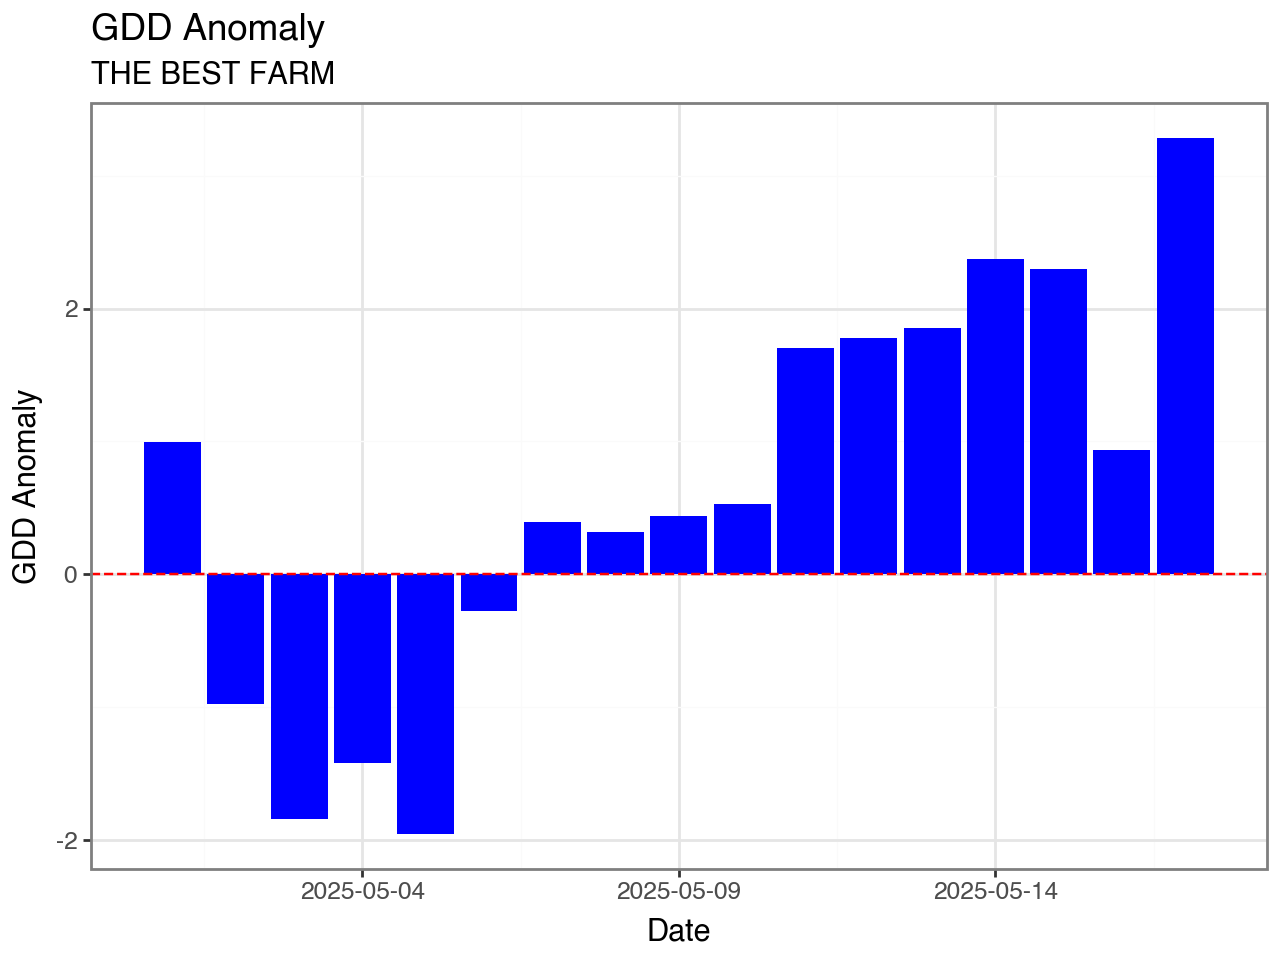

In [21]:
# QUICK PLOT TO CHECK SANITY 

from plotnine import * 

fcast_temp['date'] = pd.to_datetime(fcast_temp['date'])

(

    ggplot(fcast_temp.groupby(['date','day','month']).mean().reset_index()) +
    geom_col(aes(x='date', y='GDD_anom'),fill = 'blue') + 
    geom_hline(yintercept=0, linetype='dashed', color='red') +
    labs(title='GDD Anomaly', subtitle = 'THE BEST FARM', x='Date', y='GDD Anomaly') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    scale_x_date(date_labels='%Y-%m-%d', date_breaks='5 days') + 
    theme_bw()  



)

In [24]:
fcast_temp

,date,day,month,ens,t2_max,t2_min,gdd,seasonal_gdd,GDD_anom
0,2025-05-01,1,5,1.0,291.47820,285.13730,5.157750,3.950437,1.207314
1,2025-05-01,1,5,2.0,293.05920,285.78674,6.272970,3.950437,2.322534
2,2025-05-01,1,5,3.0,292.06467,284.58230,5.173485,3.950437,1.223048
3,2025-05-01,1,5,4.0,289.50990,285.79758,4.503740,3.950437,0.553304
4,2025-05-01,1,5,5.0,289.64447,283.59580,3.470135,3.950437,-0.480301
...,...,...,...,...,...,...,...,...,...
522,2025-05-17,17,5,27.0,293.76508,293.76508,10.615080,7.123752,3.491329
523,2025-05-17,17,5,28.0,294.36188,294.36188,11.211880,7.123752,4.088129
524,2025-05-17,17,5,29.0,286.93817,286.93817,3.788170,7.123752,-3.335581
525,2025-05-17,17,5,30.0,295.82477,295.82477,12.674770,7.123752,5.551019


In [29]:
fcast_agg = fcast_temp.groupby(['date','day','month']).agg({'gdd': ['mean', 'min','max']}).reset_index()
fcast_agg.columns = ['date','day','month','gdd_mean','gdd_min','gdd_max']

In [30]:
fcast_agg = fcast_agg.merge(farmSeasonal[['day', 'month', 'seasonal_gdd']], on=['day', 'month'], how='left')

In [32]:
fcast_agg.head()

,date,day,month,gdd_mean,gdd_min,gdd_max,seasonal_gdd
0,2025-05-01,1,5,4.943316,3.39384,6.272970,3.950437
1,2025-05-02,2,5,3.268761,1.87048,4.391385,4.244101
2,2025-05-03,3,5,2.271934,0.47378,3.175000,4.111377
3,2025-05-04,4,5,3.366729,1.42500,4.475000,4.781820
4,2025-05-05,5,5,3.652392,1.62500,5.329860,5.607686


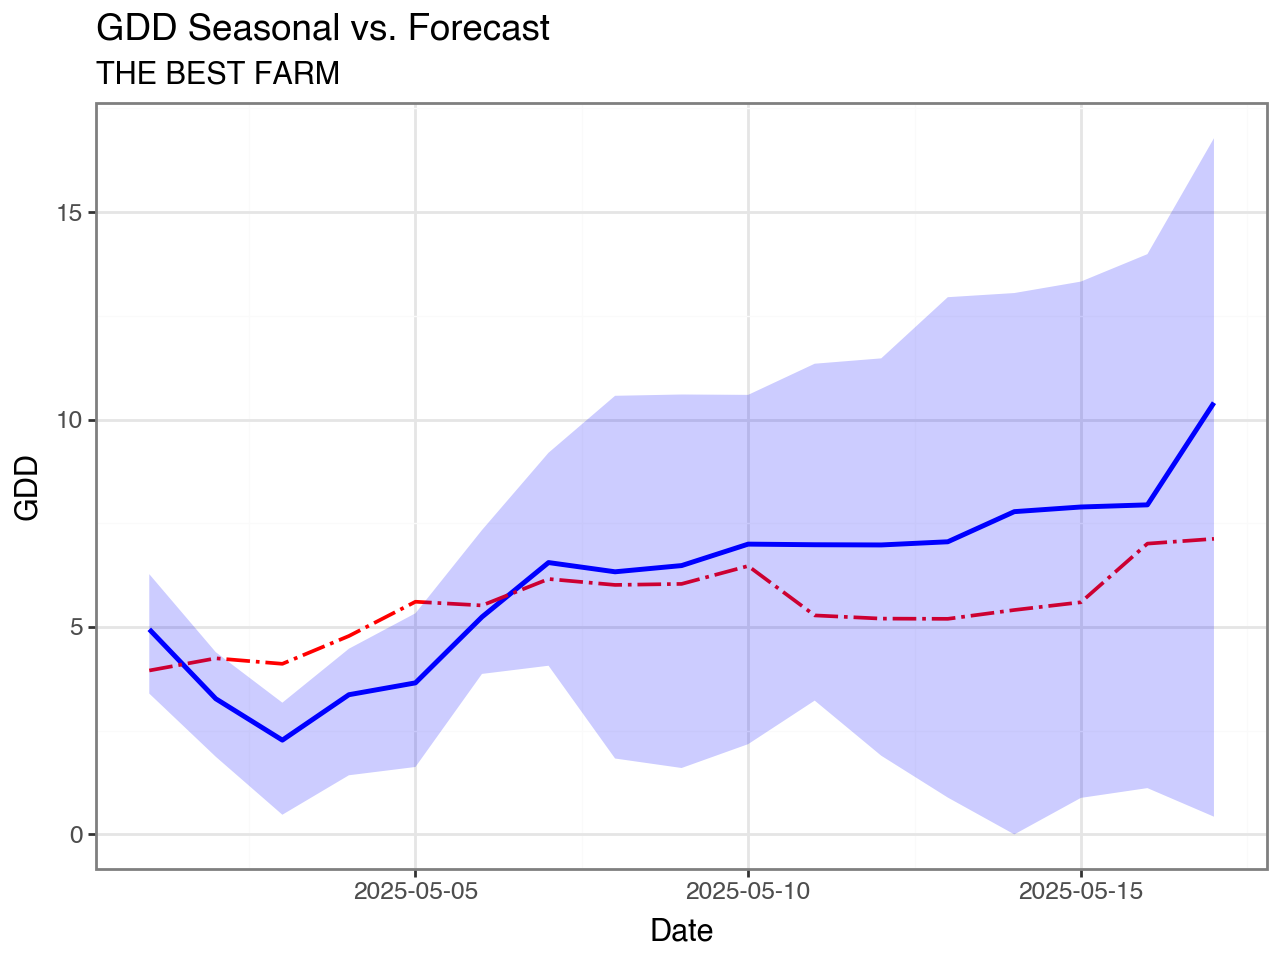

In [33]:
(

    ggplot(fcast_agg) +
    geom_line(aes(x='date', y='gdd_mean'),color = 'blue',size =1) + 
    geom_line(aes(x='date', y='seasonal_gdd'),color = 'red', linetype = 'dashdot', size = .75) +
    geom_ribbon(aes(x='date', ymin='gdd_min', ymax='gdd_max'), alpha=0.2, fill='blue') +
    labs(title='GDD Seasonal vs. Forecast', subtitle = 'THE BEST FARM', x='Date', y='GDD') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) +
    scale_x_date(date_labels='%Y-%m-%d', date_breaks='5 days') + 
    theme_bw()  



)